In [1]:
#import packages 
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, string
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

In [2]:
#import tweet data
data = pd.read_csv("tweets_tagged.csv",delimiter=',', encoding='latin-1')
print(data.head())
print(data.describe())

   Sr No                                              tweet  label
0      1  Hysteria surrounding #coronavirus NZ daycare r...      3
1      2  Thank you @TheOnion for dragging all of us und...      1
2      3  #avetmissdone is catching on faster than the #...      1
3      4  They just said #Tonysnell was back from the fl...      2
4      5  Forget locking them up on an island to die slo...      2
             Sr No         label
count  10000.00000  10000.000000
mean    5000.50000      1.879200
std     2886.89568      0.784518
min        1.00000      1.000000
25%     2500.75000      1.000000
50%     5000.50000      2.000000
75%     7500.25000      3.000000
max    10000.00000      3.000000


In [3]:
#remove urls 
def remove_URL(sample):
    """Remove URLs from a string"""
    return re.sub(r"http\S+", "", sample)
print(data['tweet'][1])
data['tweet']=[remove_URL(tweet) for tweet in data['tweet']]
print(data['tweet'][1])

Thank you @TheOnion for dragging all of us under the artful guise of satire. V helpful #coronavirus advice ?? https://t.co/Oly95Sul5f
Thank you @TheOnion for dragging all of us under the artful guise of satire. V helpful #coronavirus advice ?? 


In [4]:
#seperate dataframe to positive, negative, and both tweets
pos_tweets =data['tweet'][data['label']==1]
neg_tweets = data['tweet'][data['label']==3]
pos_neg_tweets = data['tweet'][data['label']!=2]

#examine the data
print(pos_neg_tweets.head())
print(len(pos_tweets)/len(pos_neg_tweets))

0    Hysteria surrounding #coronavirus NZ daycare r...
1    Thank you @TheOnion for dragging all of us und...
2    #avetmissdone is catching on faster than the #...
5    Please keep posted!?????? #CoronaVirus #Gensan...
6     What did Richard Jefferson say? ?? #coronavirus 
Name: tweet, dtype: object
0.5958730158730159


In [5]:
#to lower case  
pos_neg_tweets = [tweet.lower() for tweet in pos_neg_tweets]
pos_tweets = [tweet.lower() for tweet in pos_tweets]
neg_tweets = [tweet.lower() for tweet in neg_tweets]

In [6]:
print(pos_tweets[:5])
print(neg_tweets[:5])

['thank you @theonion for dragging all of us under the artful guise of satire. v helpful #coronavirus advice ?? ', '#avetmissdone is catching on faster than the #coronavirus... but no deaths yet! ??', '#wuhancoronavirus #coronavirus\na young man was recovered and discharged from a local hospital in shanxi. best wishes! ???\n', '#wuhancoronavirus #coronavirus\na young man was recovered and discharged from the local hospital in shanxi. best wishes! ????????? ', 'japan flies citizens home from virus-hit wuhan  via @youtube #coronavirus ??']
['hysteria surrounding #coronavirus nz daycare requesting all children who have visited a country with any confirmed cases be excluded for 2 weeks. this includes australia. so, despite us only visiting adelaide where there are no confirmed cases, we are in this category ??', 'please keep posted!?????? #coronavirus #gensan #stelizabethhospitalinc #sehi ', 'what did richard jefferson say? ?? #coronavirus ', 'halt???\nall??commercial??flights??from #china

In [7]:
#convert emojis and emoticons to words before tokenizing - this seems to be useless as emojis are not preserved in the raw data

#Function for converting emojis into word
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
    return text


# Function for converting emoticons into word
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

#apply to tweets
pos_tweets=[convert_emojis(tweet) for tweet in pos_tweets]
neg_tweets=[convert_emojis(tweet) for tweet in neg_tweets]
pos_tweets=[convert_emoticons(tweet) for tweet in pos_tweets]
neg_tweets=[convert_emoticons(tweet) for tweet in neg_tweets]

#example
text1 = "Hilarious 😂. The feeling of making a sale 😎, The feeling of actually fulfilling orders 😒"
convert_emojis(text1)

'Hilarious face_with_tears_of_joy. The feeling of making a sale smiling_face_with_sunglasses, The feeling of actually fulfilling orders unamused_face'

In [8]:
#use Tweet tokenizer (preserves hashtag and @)
tknzr = TweetTokenizer()

pos_tokens = [tknzr.tokenize(tweet) for tweet in pos_tweets]
neg_tokens = [tknzr.tokenize(tweet) for tweet in neg_tweets]
tweet_tokens = [tknzr.tokenize(tweet) for tweet in pos_neg_tweets]
print(pos_tokens[1])
print(neg_tokens[1])
print(tweet_tokens[1])

['#avetmissdone', 'is', 'catching', 'on', 'faster', 'than', 'the', '#coronavirus', '...', 'but', 'no', 'deaths', 'yet', '!', '?', '?']
['please', 'keep', 'posted', '!', '?', '?', '?', '#coronavirus', '#gensan', '#stelizabethhospitalinc', '#sehi']
['thank', 'you', '@theonion', 'for', 'dragging', 'all', 'of', 'us', 'under', 'the', 'artful', 'guise', 'of', 'satire', '.', 'v', 'helpful', '#coronavirus', 'advice', '?', '?']


In [9]:
#normalization 
#tagging position of word in sentence
#show example for first tweet
print(pos_tag(tweet_tokens[1]))

[('thank', 'NN'), ('you', 'PRP'), ('@theonion', 'VBP'), ('for', 'IN'), ('dragging', 'VBG'), ('all', 'DT'), ('of', 'IN'), ('us', 'PRP'), ('under', 'IN'), ('the', 'DT'), ('artful', 'JJ'), ('guise', 'NN'), ('of', 'IN'), ('satire', 'NN'), ('.', '.'), ('v', 'NN'), ('helpful', 'JJ'), ('#coronavirus', 'NN'), ('advice', 'NN'), ('?', '.'), ('?', '.')]


In [10]:
#remove noise and lemmatize (copy and pasted from blog)

    #I dont know how to remove the following : ''...' '..' '``'
    #I found this command to delete all punctuation: s.translate(str.maketrans('', '', string.punctuation)). how would I apply it?
def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        #token = re.sub("(@[A-Za-z0-9_]+)","", token) #this would delete @handles?
        token=re.sub("([^A-Za-z#])","", token) #this deletes all numbers and punctuations, though it also transforms #ncov19 to #ncov
        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)
        #use if condition to drop single character strings
        if len(token) > 1 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [11]:
#define stopwords to remove
stop_words = stopwords.words('english')

In [12]:
#apply remove_noise function
pos_tokens_cleaned = []
neg_tokens_cleaned = []
tweet_tokens_cleaned = []

for tokens in pos_tokens:
    pos_tokens_cleaned.append(remove_noise(tokens, stop_words))

for tokens in neg_tokens:
    neg_tokens_cleaned.append(remove_noise(tokens, stop_words))

for tokens in tweet_tokens:
    tweet_tokens_cleaned.append(remove_noise(tokens, stop_words))

In [13]:
print(pos_tokens_cleaned[0])
print(neg_tokens_cleaned[0])
print(tweet_tokens_cleaned[0])

['thank', 'theonion', 'drag', 'us', 'artful', 'guise', 'satire', 'helpful', '#coronavirus', 'advice']
['hysteria', 'surround', '#coronavirus', 'nz', 'daycare', 'request', 'child', 'visit', 'country', 'confirmed', 'case', 'exclude', 'week', 'include', 'australia', 'despite', 'us', 'visit', 'adelaide', 'confirmed', 'case', 'category']
['hysteria', 'surround', '#coronavirus', 'nz', 'daycare', 'request', 'child', 'visit', 'country', 'confirmed', 'case', 'exclude', 'week', 'include', 'australia', 'despite', 'us', 'visit', 'adelaide', 'confirmed', 'case', 'category']


In [14]:
#Frequencies with get_all_words
def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

all_tokens = get_all_words(tweet_tokens_cleaned)


In [15]:
#word frequencies for all words - this does not allow to plot a histogram
freq_dist = FreqDist(all_tokens)
print(freq_dist.most_common(50))

[('#coronavirus', 6311), ('china', 737), ('case', 598), ('#coronavirusoutbreak', 575), ('virus', 520), ('#ncov', 510), ('#china', 490), ('spread', 473), ('people', 466), ('get', 365), ('coronavirus', 332), ('#wuhan', 318), ('new', 306), ('death', 305), ('safe', 297), ('go', 270), ('mask', 268), ('late', 262), ('update', 260), ('like', 259), ('us', 256), ('time', 254), ('know', 241), ('outbreak', 241), ('health', 234), ('confirm', 229), ('day', 229), ('say', 227), ('wuhan', 226), ('please', 221), ('corona', 220), ('stay', 217), ('good', 216), ('country', 208), ('news', 208), ('one', 206), ('world', 203), ('infect', 202), ('need', 197), ('make', 196), ('take', 188), ('dont', 183), ('everyone', 181), ('chinese', 180), ('report', 170), ('hospital', 165), ('first', 164), ('see', 164), ('im', 161), ('patient', 160)]


In [16]:
#count words with counter function to later drop most frequent words and plot a histogram

word_counter={}
for tweet in tweet_tokens_cleaned:
    for word in tweet:
        if word != '':
            if word in word_counter:
                word_counter[word] +=1
            else:
                word_counter[word] = 1

popular_words = sorted(word_counter, key = word_counter.get, reverse = True)
top_50=popular_words[:50]
top_10 = popular_words[:10]
#print top 50 words
print(top_50)  
 

['#coronavirus', 'china', 'case', '#coronavirusoutbreak', 'virus', '#ncov', '#china', 'spread', 'people', 'get', 'coronavirus', '#wuhan', 'new', 'death', 'safe', 'go', 'mask', 'late', 'update', 'like', 'us', 'time', 'know', 'outbreak', 'health', 'confirm', 'day', 'say', 'wuhan', 'please', 'corona', 'stay', 'good', 'country', 'news', 'one', 'world', 'infect', 'need', 'make', 'take', 'dont', 'everyone', 'chinese', 'report', 'hospital', 'first', 'see', 'im', 'patient']


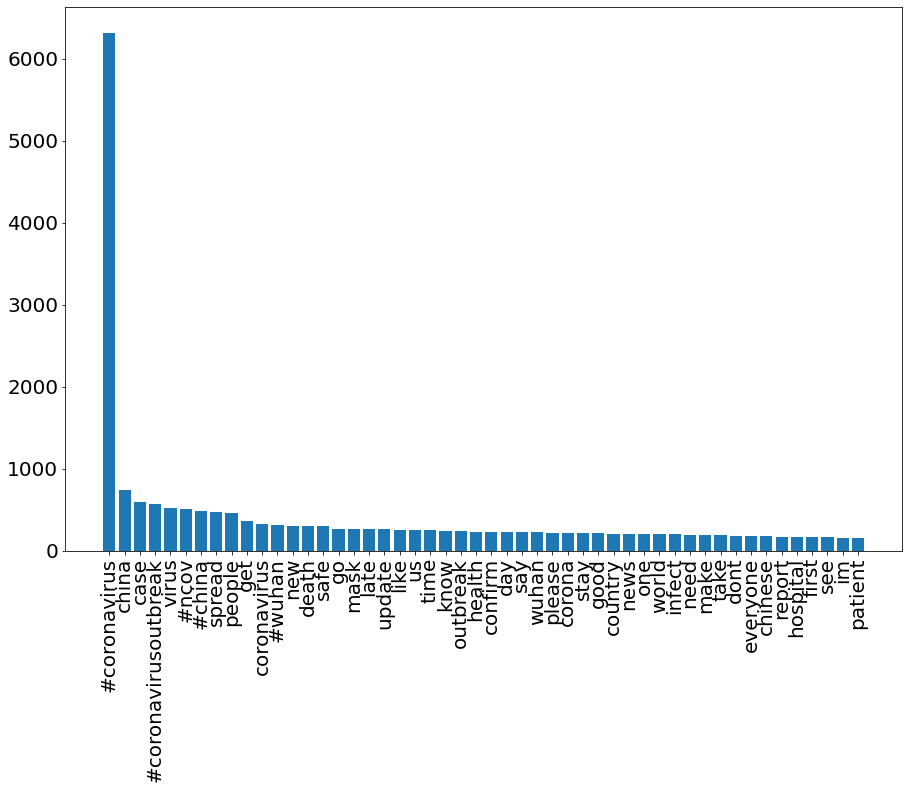

In [17]:
#plot most distribution of 50 most common words
#get values of word_counter for most common 50 words
freq = []
words = []
sorted_freq=dict(sorted(word_counter.items(), key=lambda item: item[1], reverse=True))
for key, value in sorted_freq.items():
    if key in top_50:
        freq.append(value)
        words.append(key)
#make bar plot of most frequent words
fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(height=freq, x=words, width=0.8)
plt.xticks(rotation=90)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.show()


In [18]:
#make list of pos and negative words from list of tweets to be able to delete most frequent words and count words looping over list
pos_words = []
neg_words = []

for tweet in pos_tokens_cleaned:
    for word in tweet:
        pos_words.append(word)
        
for tweet in neg_tokens_cleaned:
    for word in tweet:
        neg_words.append(word)
 


In [19]:
#count and plot top words in positive and negative tweets that are not in top50
count_pos={}
for word in pos_words:
    if word not in top_50:
        if word in count_pos:
            count_pos[word] +=1
        else:
            count_pos[word] = 1

popular_pos_words = sorted(count_pos, key = count_pos.get, reverse = True)
top_20_pos_words=popular_pos_words[:20]
count_neg={}
for word in neg_words:
    if word not in top_50:
        if word in count_neg:
            count_neg[word] +=1
        else:
            count_neg[word] = 1

popular_neg_words = sorted(count_neg, key = count_neg.get, reverse = True)
top_20_neg_words=popular_neg_words[:20]

In [20]:
#get frequencies from dictionaries in a sorted way as tuples for plotting top20
#positive
freq_pos = []
words_pos = []
sorted_freq_pos= [(k, v) for k, v in count_pos.items()]
sorted_freq_pos=sorted(sorted_freq_pos, key=lambda tup: tup[1], reverse=True)
words_pos = [a for (a,_) in sorted_freq_pos]
freq_pos = [b for (_,b) in sorted_freq_pos]




In [21]:
#negative
freq_neg = []
words_neg = []
sorted_freq_neg= [(k, v) for k, v in count_neg.items()]
sorted_freq_neg=sorted(sorted_freq_neg, key=lambda tup: tup[1], reverse=True)
words_neg = [a for (a,_) in sorted_freq_neg]
freq_neg = [b for (_,b) in sorted_freq_neg]



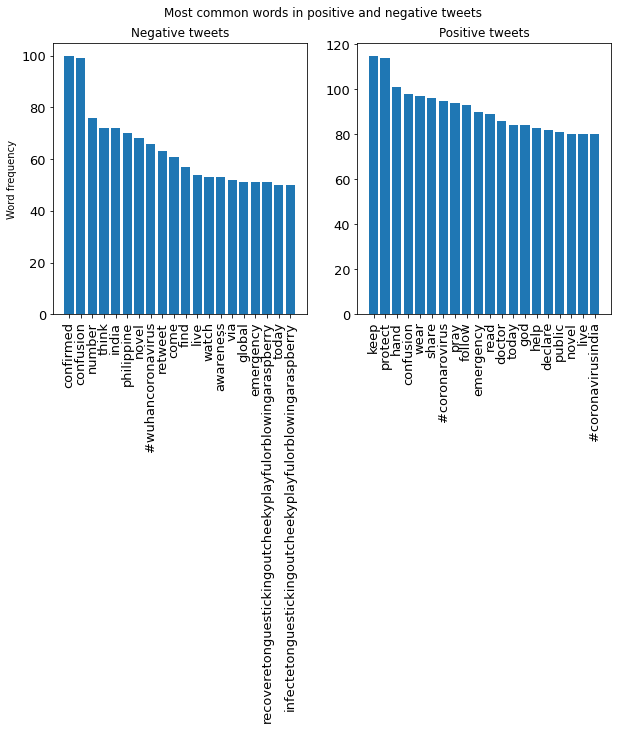

In [22]:
#make bar plot of frequencies 
fig, ax = plt.subplots(figsize=(10, 5))
plt.subplot(1,2,1)

#This will create first plot
neg = plt.bar(words_neg[:20], freq_neg[:20])
plt.title('Negative tweets')
plt.ylabel('Word frequency')
plt.xticks(rotation='vertical')
plt.tick_params(axis='both', which='major', labelsize=13)
#The below code will create the second plot.
plt.subplot(1,2,2)
#This will create the second plot
pos =plt.bar(words_pos[:20], freq_pos[:20])
plt.title('Positive tweets')
plt.xticks( rotation='vertical')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.suptitle('Most common words in positive and negative tweets')
plt.show() 

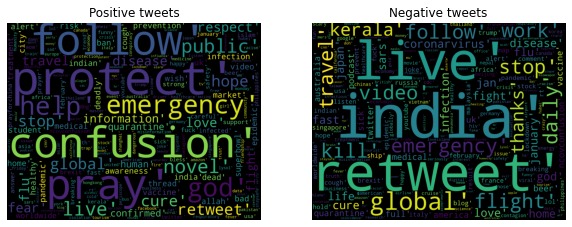

In [23]:
#in addition make word cloud as alternative illustration

from wordcloud import WordCloud
fig, ax = plt.subplots(figsize=(10, 5))

#positive
plt.subplot(1,2,1)
wordcloud_pos = WordCloud(width=1800,height=1400).generate(str(words_pos))
plt.imshow(wordcloud_pos)
plt.title('Positive tweets')
plt.axis("off")

#negative
plt.subplot(1,2,2)
wordcloud_neg = WordCloud(width=1800,height=1400).generate(str(words_neg))
plt.imshow(wordcloud_neg)
plt.title('Negative tweets')
plt.axis("off")

plt.show()

In [24]:
#preparing data for modelling
#make dict out of lists of tokens with keys = tokens and values=true

def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

positive_tokens_for_model = get_tweets_for_model(pos_tokens_cleaned)
negative_tokens_for_model = get_tweets_for_model(neg_tokens_cleaned)

In [25]:
#test and training set split for Naive Bayes model
#joining positive and negative tweets with additional tag, and shuffle into 1 set
import random

positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset
random.shuffle(dataset)

#we have 6,300 tweets after dropping the neutral ones
train_size=int(len(dataset)*0.7) # set training dataset size to 0.7 of all data
print(train_size)
train_data = dataset[:train_size]
test_data = dataset[train_size:]
print(dataset[:5])

4410
[({'gross': True, 'misinformation': True, 'spread': True, 'regard': True, '#wuhan': True, '#coronavirus': True, 'study': True, 'reference': True, 'indicate': True, 'develop': True, 'acute': True, 'respiratory': True, 'distress': True, 'syndrome': True, 'die': True, 'mean': True, 'developed': True, 'ards': True, 'go': True, 'doesnt': True, 'mortality': True}, 'Positive'), ({'reading': True, 'article': True, '#coronavirus': True, 'every': True, 'see': True, 'comment': True, 'chinese': True, 'described': True, 'selfish': True, 'barbaric': True, 'uncivilised': True, 'filth': True, '#sinophobia': True, 'nothing': True, 'new': True, 'let': True, 'bask': True, 'ignorance': True, 'stunt': True, 'growth': True}, 'Positive'), ({'number': True, 'human': True, '#coronavirus': True}, 'Positive'), ({'#coronavirus': True, '#china': True, 'complete': True, 'construction': True, 'makeshift': True, 'hospital': True, 'day': True, 'confirmed': True, 'case': True, 'china': True, '#africa': True, 'suda

In [26]:
#Using NLTK Package to build Naive Bayes Model - it has slightly different accuracy from sklean Naive Bayes module below ...how?
from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))
print(classifier.show_most_informative_features(10))


Accuracy is: 0.5851851851851851
Most Informative Features
                database = True           Negati : Positi =     21.1 : 1.0
infectetonguestickingoutcheekyplayfulorblowingaraspberry = True           Negati : Positi =     15.1 : 1.0
                 respect = True           Positi : Negati =     13.1 : 1.0
recoveretonguestickingoutcheekyplayfulorblowingaraspberry = True           Negati : Positi =      9.9 : 1.0
                 finland = True           Negati : Positi =      8.4 : 1.0
                      nd = True           Positi : Negati =      7.6 : 1.0
                 podcast = True           Negati : Positi =      7.4 : 1.0
                    heal = True           Positi : Negati =      6.5 : 1.0
             #loveisland = True           Negati : Positi =      6.4 : 1.0
                #peruzzi = True           Negati : Positi =      6.4 : 1.0
None


In [27]:
#Transform dataset to use other models
#requires count vectorization - basically the same as above but would take into account when tokens occur multiple times in tweet?!
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Create our vectorizer
vectorizer = CountVectorizer()



In [28]:
#to use count vectorization, format of x (tweets) needs to be a simple list of strings

neg_list = []
pos_list = []

for tweet in neg_tokens_cleaned:
    tw=''
    for word in tweet:
        tw=tw+word+' '
    tw=tw[:-1] #get rid of space at the end of tweet
    neg_list.append(tw)

for tweet in pos_tokens_cleaned:
    tw=''
    for word in tweet:
        tw=tw+word+' '
    tw=tw[:-1] #get rid of space at the end of tweet
    pos_list.append(tw)
    
#add positive and negative category and shuffle

pos_set = [(tweet, 1)
                     for tweet in pos_list]


neg_set = [(tweet, 0)
                     for tweet in neg_list]

ds = pos_set + neg_set
random.shuffle(ds)

#we have 6,300 tweets after dropping the neutral ones
train_size=int(len(ds)*0.7) # set training dataset size to 0.7 of all data
print(train_size)
train_data = ds[:train_size]
test_data = ds[train_size:]


#generate x_train, y_train, x_test, y_test
x_test = [a for (a,_) in test_data]
x_train = [a for (a,_) in train_data]
y_test = [b for (_,b) in test_data]
y_train = [b for (_,b) in  train_data]



# Get the training vectors
vectors = vectorizer.fit_transform(x_train)


# Get the test vectors
vectors_test = vectorizer.transform(x_test)



4410


In [29]:
#Naive Bayes
# Build the classifier
nb= MultinomialNB(alpha=.01)

#  Train the classifier
nb.fit(vectors, y_train)

# Predict and score the vectors
nb_pred = nb.predict(vectors_test)
nb_acc_score = metrics.accuracy_score(y_test, nb_pred)
nb_f1_score = metrics.f1_score(y_test, nb_pred, average='macro')

print('Naive Bayes: Total accuracy classification score: {}'.format(nb_acc_score))
print('Naive Bayes: Total F1 classification score: {}'.format(nb_f1_score))


Naive Bayes: Total accuracy classification score: 0.5888888888888889
Naive Bayes: Total F1 classification score: 0.5688973656160032


In [30]:
#Logistic regression

# Build the classifier
lr= LogisticRegression()

#  Train the classifier
lr.fit(vectors, y_train)

# Predict and score the vectors
lr_pred = lr.predict(vectors_test)
lr_acc_score = metrics.accuracy_score(y_test, lr_pred)
lr_f1_score = metrics.f1_score(y_test, lr_pred, average='macro')

print('Logistic Regression: Total accuracy classification score: {}'.format(lr_acc_score))
print('Logistic Regression: Total F1 classification score: {}'.format(lr_f1_score))

Logistic Regression: Total accuracy classification score: 0.5962962962962963
Logistic Regression: Total F1 classification score: 0.5668224968617183


In [31]:
#Decision tree classifier

# Build the classifier
dt= DecisionTreeClassifier()

#  Train the classifier
dt.fit(vectors, y_train)

# Predict and score the vectors
dt_pred = dt.predict(vectors_test)
dt_acc_score = metrics.accuracy_score(y_test, dt_pred)
dt_f1_score = metrics.f1_score(y_test, dt_pred, average='macro')

print('Decision Tree Classifier: Total accuracy classification score: {}'.format(dt_acc_score))
print('Decision Tree Classifier: Total F1 classification score: {}'.format(dt_f1_score))

Decision Tree Classifier: Total accuracy classification score: 0.5650793650793651
Decision Tree Classifier: Total F1 classification score: 0.5551764657376104


In [32]:
#Random forest classifier

# Build the classifier
rf= RandomForestClassifier()

#  Train the classifier
rf.fit(vectors, y_train)

# Predict and score the vectors
rf_pred = rf.predict(vectors_test)
rf_acc_score = metrics.accuracy_score(y_test, rf_pred)
dt_f1_score = metrics.f1_score(y_test, rf_pred, average='macro')

print('Random Forest Classifier: Total accuracy classification score: {}'.format(dt_acc_score))
print('Random Forest Classifier: Total F1 classification score: {}'.format(dt_f1_score))

Random Forest Classifier: Total accuracy classification score: 0.5650793650793651
Random Forest Classifier: Total F1 classification score: 0.5888420414992019


In [33]:
#ROC curve

#import packages
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities for each of the classifiers
nb_probs = nb.predict_proba(vectors_test) #naive bayes
lr_probs = lr.predict_proba(vectors_test) #logistic regression
dt_probs = dt.predict_proba(vectors_test) #decision tree classifier
rf_probs = rf.predict_proba(vectors_test) #random forest classifier

# keep probabilities for the positive outcome only
nb_probs=nb_probs[:, 1]
lr_probs=lr_probs[:, 1]
dt_probs=dt_probs[:, 1]
rf_probs=rf_probs[:, 1]



No Skill: ROC AUC=0.500
Naive Bayes: ROC AUC=0.594
Logistic: ROC AUC=0.619
Decision Tree: ROC AUC=0.554
Random forest: ROC AUC=0.629


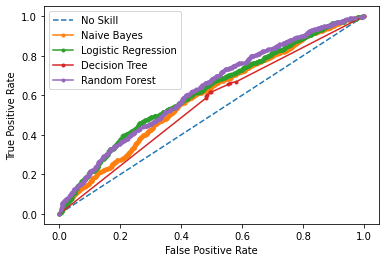

In [34]:
# calculate roc auc scores
ns_auc = roc_auc_score(y_test, ns_probs) #no skill
nb_auc = roc_auc_score(y_test, nb_probs) #naive bayes
lr_auc = roc_auc_score(y_test, lr_probs) #logistic regression
dt_auc = roc_auc_score(y_test, dt_probs) #decision tree
rf_auc = roc_auc_score(y_test, rf_probs) #random forests


# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Naive Bayes: ROC AUC=%.3f' % (nb_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('Decision Tree: ROC AUC=%.3f' % (dt_auc))
print('Random forest: ROC AUC=%.3f' % (rf_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()